In [1]:
import pandas as pd
import numpy as np
import torch
from attention_analysis import *
from collections import Counter

In [2]:
## Loading Models
from transformers import GPT2Tokenizer, GPT2LMHeadModel
tokenizer_gpt2 = GPT2Tokenizer.from_pretrained('gpt2')
model_gpt2 = GPT2LMHeadModel.from_pretrained('gpt2', output_attentions = True)

In [3]:
def get_attention_all(sent,source, target, tokenizer,model):
    indexed_tokens = tokenizer.encode(sent)
    tokens = [tokenizer.decode(i).strip() for i in indexed_tokens]
    target_loc, source_loc = tokens.index(target), tokens.index(source)
    attn_val=torch.tensor(attention(sent, model, tokenizer).attn_data['all']['attn'])[:,:,target_loc,source_loc]
    return attn_val

In [4]:
#Compute metrics for subjects

cunnings = pd.read_csv('cunnings2018.csv')
_id = np.unique(cunnings["id"])


dep_pl_effects = torch.zeros(12,12)
dep_acc = torch.zeros(12,12)

dist_pl_effects = torch.zeros(12,12)
dist_acc = torch.zeros(12,12)
dep_count,dist_count = 0, 0
for i in _id:

    _set = cunnings[cunnings['id']==i]
    plpl_sent = _set[_set['cond']=='pl_pl'].sent.item()
    plimpl_sent = _set[_set['cond']=='pl_impl'].sent.item()
    implpl_sent = _set[_set['cond']=='impl_pl'].sent.item()
    implimpl_sent = _set[_set['cond']=='impl_impl'].sent.item()
    
    pl_subj = _set[_set['cond']=='pl_impl'].subj.item()
    impl_subj = _set[_set['cond']=='impl_impl'].subj.item()
    pl_dist = _set[_set['cond']=='pl_pl'].dist.item()
    impl_dist = _set[_set['cond']=='pl_impl'].dist.item()
    
    verb = _set[_set['cond']=='pl_impl'].verb.item()
    
    plpl_indexed_tokens = tokenizer_gpt2.encode(plpl_sent)
    plpl_tokens = [tokenizer_gpt2.decode(i).strip() for i in plpl_indexed_tokens]
    implimpl_indexed_tokens = tokenizer_gpt2.encode(implimpl_sent)
    implimpl_tokens = [tokenizer_gpt2.decode(i).strip() for i in implimpl_indexed_tokens]

    if (verb in plpl_tokens) and (pl_subj in plpl_tokens) and (impl_subj in implimpl_tokens):
        dep_count+=1
        plsub_attn = get_attention_all(plpl_sent, pl_subj, verb, tokenizer_gpt2, model_gpt2)
        implsub_attn = get_attention_all(implpl_sent, impl_subj, verb, tokenizer_gpt2, model_gpt2)
        dep_pl_effects += plsub_attn-implsub_attn
        dep_acc += ((plsub_attn*10>implsub_attn*10)).type(torch.uint8) 
        
        dep_count+=1
        plsub_attn = get_attention_all(plimpl_sent, pl_subj, verb, tokenizer_gpt2, model_gpt2)
        implsub_attn = get_attention_all(implimpl_sent, impl_subj, verb, tokenizer_gpt2, model_gpt2)
        dep_pl_effects += plsub_attn-implsub_attn
        dep_acc += ((plsub_attn*10>implsub_attn*10)).type(torch.uint8)         


    if (verb in plpl_tokens) and (pl_dist in plpl_tokens) and (impl_dist in implimpl_tokens):
        dist_count+=1
        pldis_attn = get_attention_all(plpl_sent, pl_dist, verb, tokenizer_gpt2, model_gpt2)
        impldis_attn = get_attention_all(plimpl_sent, impl_dist, verb, tokenizer_gpt2, model_gpt2)
        dist_pl_effects += pldis_attn-impldis_attn
        dist_acc += ((pldis_attn*10>impldis_attn*10)).type(torch.uint8) 

    if (verb in plpl_tokens) and (pl_dist in plpl_tokens) and (impl_dist in implimpl_tokens):
        dist_count+=1
        pldis_attn = get_attention_all(implpl_sent, pl_dist, verb, tokenizer_gpt2, model_gpt2)
        impldis_attn = get_attention_all(implimpl_sent, impl_dist, verb, tokenizer_gpt2, model_gpt2)
        dist_pl_effects += pldis_attn-impldis_attn
        dist_acc += ((pldis_attn*10>impldis_attn*10)).type(torch.uint8) 

dep_pl_effects=pd.DataFrame(np.array(dep_pl_effects))
dep_acc=pd.DataFrame(np.array(dep_acc/dep_count))

dist_pl_effects=pd.DataFrame(np.array(dist_pl_effects))
dist_acc=pd.DataFrame(np.array(dist_acc/dist_count))

In [5]:
def create_heatmaps(effect, acc, acc_other_condition, title, xlabel, ylabel, cbar = False,  vmin=-2, vmax=5, threshold = 0.7):
    plt.figure(figsize = (8,8))
    params = [
        {"mask": (acc > threshold) & (acc_other_condition > threshold) == False,
         "annot_kws": {"weight": "bold", 'color':'yellow','fontsize':14}},
        {"mask": (acc > threshold) & (acc_other_condition <= threshold) == False,
         "annot_kws": {'color':'yellow','fontsize':14}},
        {"mask": (acc <= threshold) == False,
         "annot_kws": {'color':'black', 'fontsize':14}}
    ]
    for param in params:
        ax= sns.heatmap(effect,
                        **param,
                        linewidth=0.5, 
                        annot=True, 
                        vmin=vmin, 
                        vmax=vmax,  
                        cbar=cbar,
                        cmap="crest",
                        fmt=".2f")
    plt.title(title, fontsize =23)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)

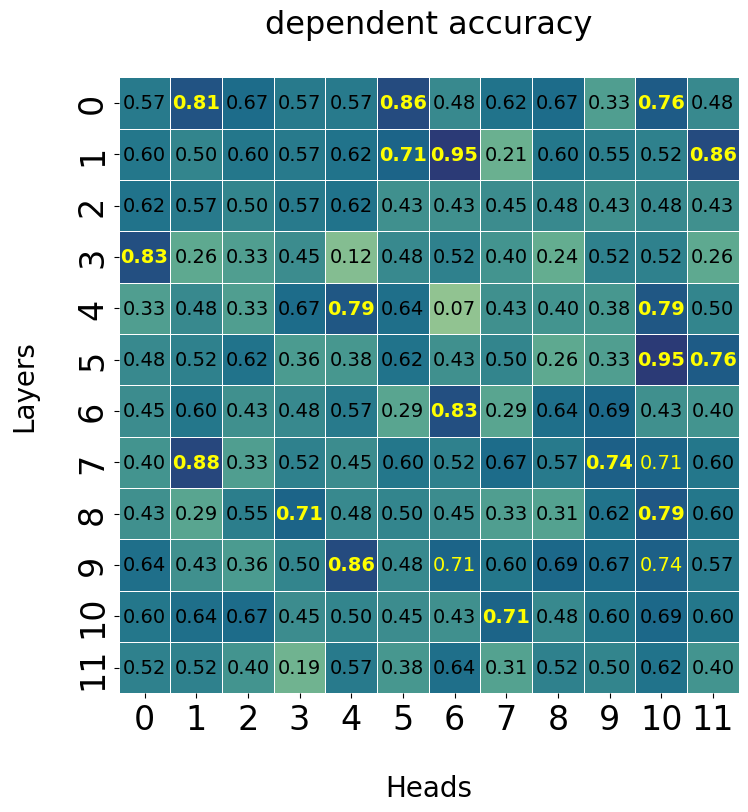

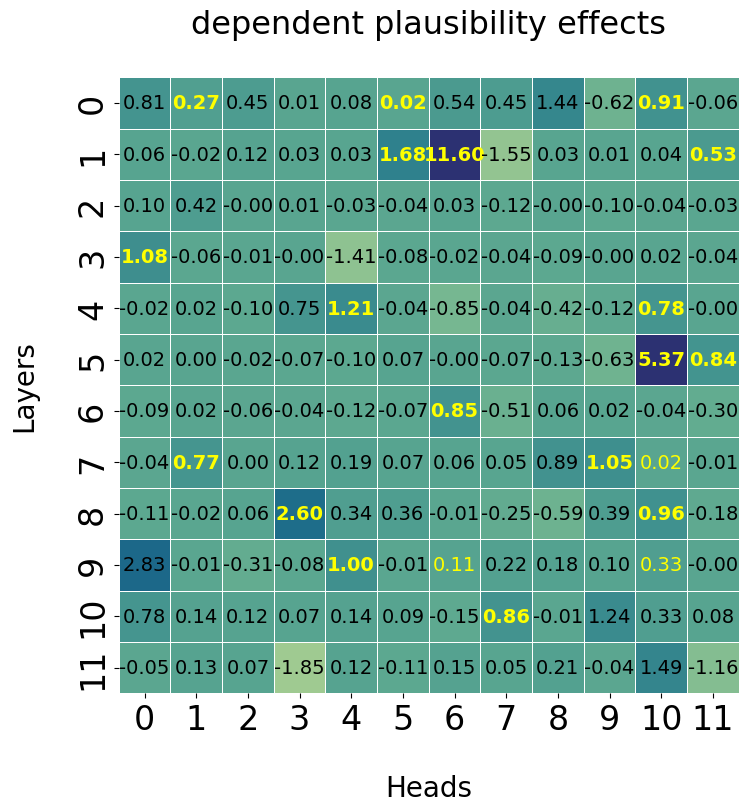

In [6]:
create_heatmaps(dep_acc, dep_acc, dist_acc, "dependent accuracy\n","\nHeads", "Layers\n",  cbar=False, vmin=0, vmax=1)
create_heatmaps(dep_pl_effects, dep_acc, dist_acc,"dependent plausibility effects\n", "\nHeads", "Layers\n",  cbar=False, vmin=-2, vmax=5)

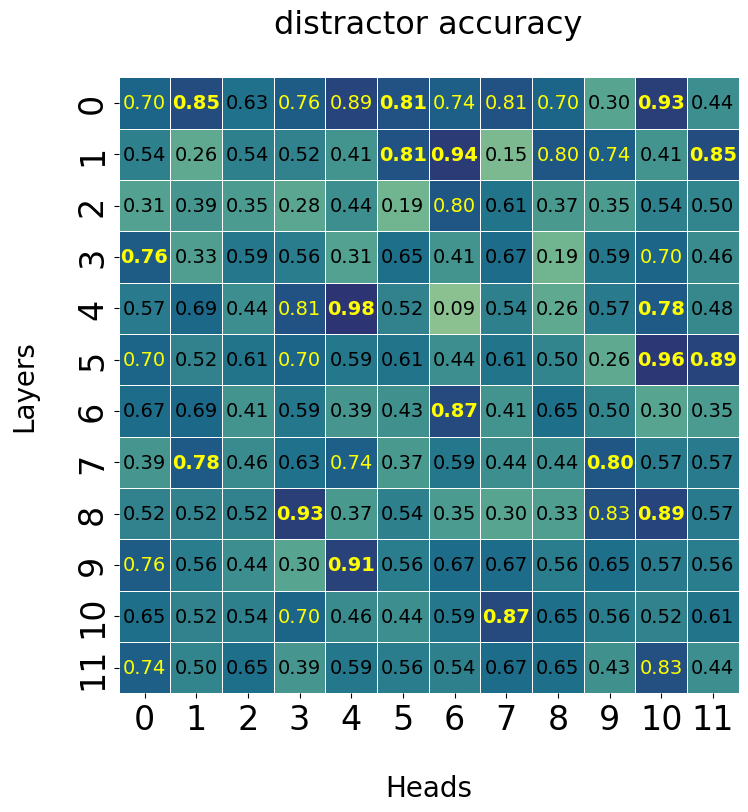

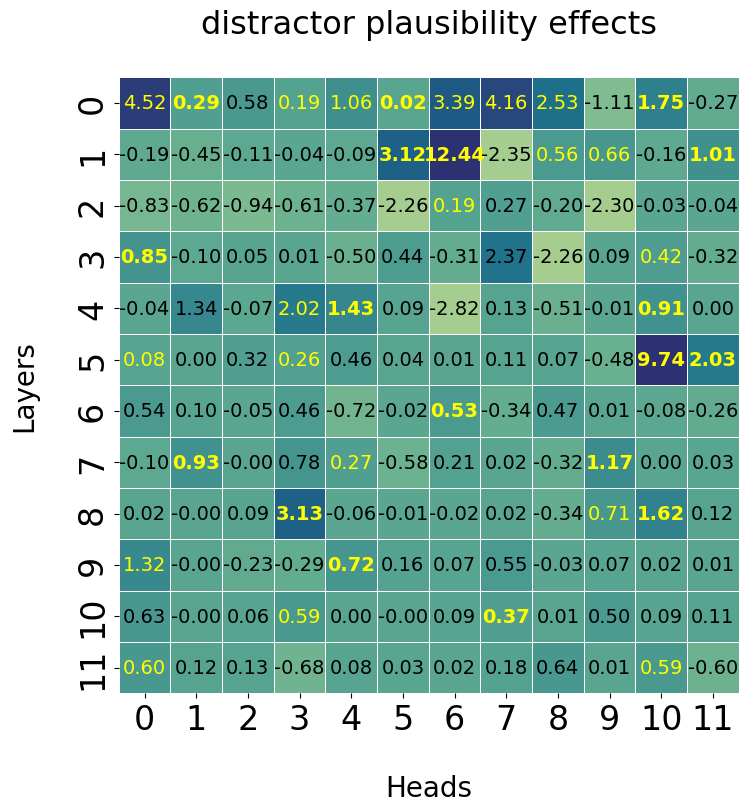

In [7]:
create_heatmaps(dist_acc, dist_acc, dep_acc, "distractor accuracy\n","\nHeads", "Layers\n",  cbar=False, vmin=0, vmax=1)
create_heatmaps(dist_pl_effects, dist_acc, dep_acc,"distractor plausibility effects\n", "\nHeads", "Layers\n",  cbar=False, vmin=-2, vmax=5)